In [7]:
import pandas as pd
import numpy as np

def load_data_from_csv(filename):
    return pd.read_csv(filename)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.list_physical_devices('GPU')

[]

In [8]:
dataset = load_data_from_csv('dataset.csv')
dataset

,word,gender
0,Keratin,n
1,Lactalbumin,n
2,Mercaptoethanol,n
3,Nduja,f
4,Vesta,f
...,...,...
376791,Nachrede,f
376792,Löschungsort,m
376793,Cejkait,m
376794,Propellerdomäne,f


In [9]:
from utils import wordToSequence, generate_classification_labels, german_characters
from functools import partial

max_characters = 7

possible_classes = ['m', 'f', 'n']

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def crop_word(word, max_length):
    return word[-max_length:]

def preprocessing(chunk):
    chunk.dropna(inplace=True)
    chunk['word'] = chunk['word'].str.lower()
    chunk['word'] = chunk['word'].apply(lambda x: crop_word(x, max_characters))
    chunk['sequence'] = chunk['word'].map(partial(wordToSequence, possible_characters=german_characters, set_length=max_characters))
    chunk['labels'] = chunk['gender'].map(partial(generate_classification_labels, classes=possible_classes))
    chunk['labels'] = chunk['labels'].map(flatten)
    return chunk

dataset = preprocessing(dataset)
len(dataset)

376795

In [10]:
from utils import split_data

train_x, train_y, val_x, val_y, test_x, test_y = split_data(dataset, ['sequence'], ['labels'])


In [11]:




def x_to_array(x, column):
    array = np.array(x[column].tolist())
    return tf.cast(array, dtype = tf.float32)


train_x = x_to_array(train_x, 'sequence')
val_x = x_to_array(val_x, 'sequence')
test_x = x_to_array(test_x, 'sequence')

train_y = x_to_array(train_y, 'labels')
val_y = x_to_array(val_y, 'labels')
test_y = x_to_array(test_y, 'labels')

print(np.shape(train_x))
print(np.shape(train_y))

(301436, 7)
(301436, 3)


In [12]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\Manu\\OneDrive\\Escritorio\\UTN\\IA\\TP_RNA\\utils.py'>

# Fifth Version: LSTMs

In [33]:
learning_rates = [0.02, 0.01, 0.005, 0.001, 0.0003]
epochs = [40, 25, 15, 10, 5]

batch_size = 64

loss = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]


In [34]:
model = keras.models.Sequential()

model.add(layers.Embedding(len(german_characters), 32, input_length=max_characters))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss=loss, metrics=metrics)

model.build(input_shape=(None, max_characters))

keras.utils.plot_model(model, to_file='model_plot_lstm1.png', show_shapes=True, show_layer_names=True)

model.summary()


c:\Users\Manu\OneDrive\Escritorio\UTN\IA\TP_RNA\TPIAVenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 7, 32)          │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,539 (68.51 KB)

 Trainable params: 17,539 (68.51 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:



histories = []
for l_rate, epochs in zip(learning_rates, epochs):
    optim = keras.optimizers.SGD(learning_rate=l_rate)
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y), verbose=2, shuffle=True)
    histories.append(history)

result = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=2)

model.summary()

model.save('model_lstm3.h5')

Epoch 1/40
4710/4710 - 14s - 3ms/step - accuracy: 0.6019 - loss: 0.4973 - val_accuracy: 0.6683 - val_loss: 0.4273
Epoch 2/40
4710/4710 - 12s - 2ms/step - accuracy: 0.7221 - loss: 0.3921 - val_accuracy: 0.7428 - val_loss: 0.3719
Epoch 3/40
4710/4710 - 12s - 3ms/step - accuracy: 0.7652 - loss: 0.3432 - val_accuracy: 0.7802 - val_loss: 0.3249
Epoch 4/40
4710/4710 - 11s - 2ms/step - accuracy: 0.8022 - loss: 0.2996 - val_accuracy: 0.8167 - val_loss: 0.2837
Epoch 5/40
4710/4710 - 14s - 3ms/step - accuracy: 0.8364 - loss: 0.2619 - val_accuracy: 0.8502 - val_loss: 0.2496
Epoch 6/40
4710/4710 - 17s - 4ms/step - accuracy: 0.8626 - loss: 0.2322 - val_accuracy: 0.8700 - val_loss: 0.2233
Epoch 7/40
4710/4710 - 15s - 3ms/step - accuracy: 0.8780 - loss: 0.2097 - val_accuracy: 0.8850 - val_loss: 0.2037
Epoch 8/40
4710/4710 - 12s - 3ms/step - accuracy: 0.8889 - loss: 0.1931 - val_accuracy: 0.8931 - val_loss: 0.1887
Epoch 9/40
4710/4710 - 11s - 2ms/step - accuracy: 0.8974 - loss: 0.1800 - val_accuracy: 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 7, 32)          │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,541 (68.52 KB)

 Trainable params: 17,539 (68.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [36]:
histories = utils.merge_histories(histories)



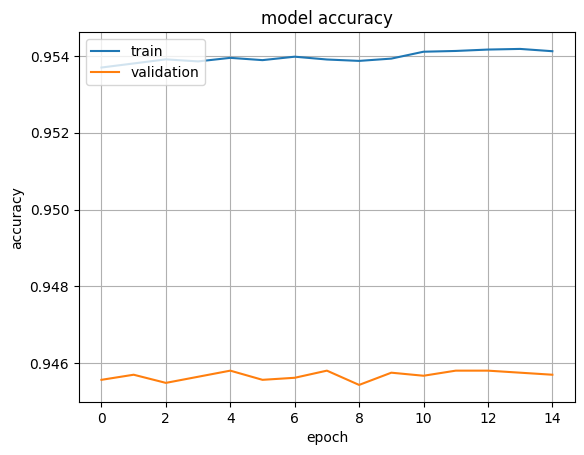

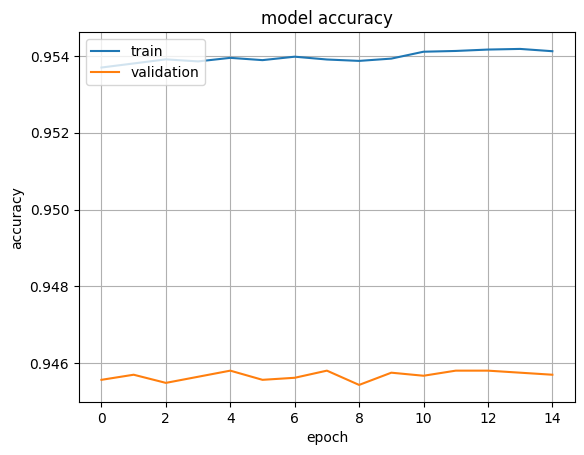

In [38]:
utils.plot_accuracy(utils.slice_history(histories, start = 80))

### First Attempt:

First attempt with an LSTM:

Changed the input to a sequence based one instead of a one-hot encoding, and lowered the max characters to 20. 

```py
learning_rates = [0.02, 0.01, 0.005, 0.001, 0.0003]
epochs = [10, 10, 10, 20, 10]

batch_size = 32

loss = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]
```

It's not a very deep network but LSTM layers seem to be much slower than conventional or convolutional ones, so making it deeper would be an issue with my current hardware. 

![model_plot_lstm1.png](plots/model_plot_lstm1.png)  

![fifth_attempt_11.png](plots/fifth_attempt_11.png)

![fifth_attempt_12.png](plots/fifth_attempt_12.png)

Seems to have fairly good accuracy, and also little overfitting. 

## Accuracy: 0.8780 

### Second Attempt:

Changed the LSTM layer to be bidirectional:

```py
model.add(layers.Bidirectional(layers.LSTM(32)))

```

```py
learning_rates = [0.02, 0.01, 0.005, 0.001, 0.0003]
epochs = [15, 10, 10, 20, 10]

batch_size = 32

loss = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]
```


![model_plot_lstm1.png](plots/model_plot_lstm2.png)  

![fifth_attempt_21.png](plots/fifth_attempt_21.png)

![fifth_attempt_22.png](plots/fifth_attempt_22.png)

Significant increase in accuracy, but at the cost of quite a lot more execution time. Realized I was lowering my learning rate too fast, since the accuracy growth had not yet stagnated by the time it was lowered.

## Accuracy: 0.8935

### Third Attempt:

Modified the amount of epochs:
```py
learning_rates = [0.02, 0.01, 0.005, 0.001, 0.0003]
epochs = [20, 20, 15, 10, 5]

batch_size = 32

loss = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]
```
Also tried to add another dense layer but it didn't work out, so I cut it short and went back to only one dense layer.

![model_plot_lstm3.png](plots/model_plot_lstm3.png)  

![fifth_attempt_31.png](plots/fifth_attempt_31.png)

![fifth_attempt_32.png](plots/fifth_attempt_32.png)

Significant increase in accuracy again, but overfitting also increased a lot.

Accuracy: 0.9067

### Fourth Attempt

The main change was to the preprocessing: instead of capping the max number of characters and excluding the longer words, the model now only receives the last n (7 in this case) characters of a word. This has two advantages: it both increases the amount of data available for training, and allows the model to focus on the more important information, which is the ending of the word. 

Also modified the number of epochs, since the accuracy was still growing by the time of the first decrease in learning rate. 

```py
learning_rates = [0.02, 0.01, 0.005, 0.001, 0.0003]
epochs = [40, 25, 15, 10, 5]

batch_size = 64

loss = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]
```

This results in an enormous gain in accuracy, approaching almost 95%.

![fifth_attempt_41.png](plots/fifth_attempt_41.png)

![fifth_attempt_42.png](plots/fifth_attempt_42.png)

### Final Accuracy: 0.9428